In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
import tensorflow as tf
from sklearn.datasets import make_spd_matrix
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline

####Answer 2

In [0]:
def linear_transform_an2(N, n, mean, covVecs, covVals, pl):
  '''
  Input: N-samples, n-dimension, mu-mean vector, sig-covariance matrix
  returns random samples generated according to priors, mu and sig
  '''
  
  # number = np.zeros(4,) 
  
  np.random.seed(2)
  tempo = np.random.rand(1,N) # generating N random samples
  pl_mod = np.cumsum(pl) # cumulative sum
  pl_mod = np.insert(pl_mod, 0, 0) # pl_mod is now [0 0.1 0.3 0.5 1] and we take ranges between them for the three classes

  x = np.zeros([n,N])
  ls = []

  for i in range(n+1):
    if (i != 2):
      number = np.where((tempo >= pl_mod[i]) & (tempo < pl_mod[i+1]))[1]
      x[:,number] = (covVecs[i,:,:]@covVals**(0.5))@np.random.multivariate_normal([0,0], np.diag([1,1]), len(number)).T + mean[:,i].reshape(2,1)
    else:
      number = np.where((tempo >= pl_mod[i]) & (tempo <= pl_mod[i+1]))[1]
      x[:,number] = (covVecs[i,:,:]@covVals**(0.5))@np.random.multivariate_normal([0,0], np.diag([1,1]), len(number)).T + mean[:,i].reshape(2,1)
    ls.append(number)
    
  return (x,ls)

In [0]:
n = 2
Ntrain = 1000
Ntest = 10000
alpha = [0.33,0.34,0.33]
meanVectors = np.array([[-18, 0, 18],[-8, 0, 8]])
covEvalues = np.array([[3.2**2, 0],[0, 0.6**2]])
covEvectors1 = np.array([[[1, -1],[1, 1]]])/np.sqrt(2)
covEvectors2 = np.array([[[1, 0],[0, 1]]])
covEvectors3 = np.array([[[1, -1],[1, 1]]])/np.sqrt(2)
covEvectors = np.concatenate((covEvectors1, covEvectors2, covEvectors3), axis = 0)

dat, cts = linear_transform_an2(Ntrain, n, meanVectors, covEvectors, covEvalues, alpha)
dat_test, cts_test = linear_transform_an2(Ntest, n, meanVectors, covEvectors, covEvalues, alpha)

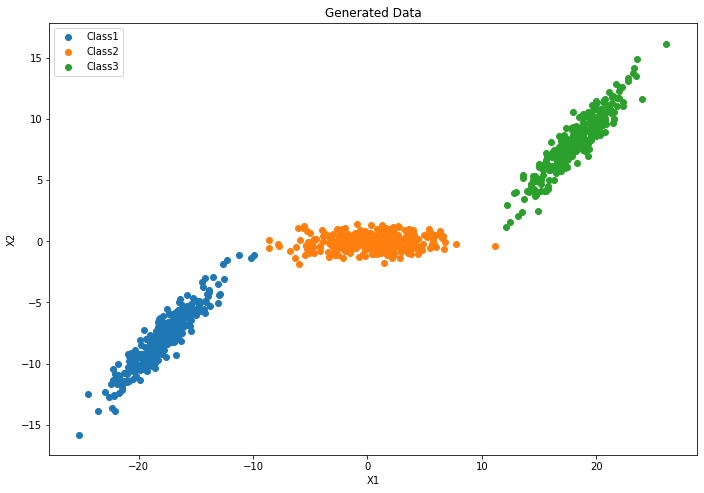

In [18]:
plt.axes([1,1,1.5,1.5])
plt.scatter(dat[0,cts[0]], dat[1,cts[0]])
plt.scatter(dat[0,cts[1]], dat[1,cts[1]])
plt.scatter(dat[0,cts[2]], dat[1,cts[2]])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Generated Data')
plt.legend(('Class1', 'Class2', 'Class3'))

In [0]:
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        la = 3.3
        if (logs.get('loss') < la):
            print('\nLoss less than {}. Hence, stopping'.format(la))
            self.model.stop_training = True
        
# Create an instance of myCallbacks()
callbacks = myCallbacks()

In [20]:
k = 10
N = 1000
main_ls_softplus = []
models = []
for nodes in range(5,51,5):
  ls = []
  model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(1,)),
            tf.keras.layers.Dense(nodes, activation = 'softplus'),
            tf.keras.layers.Dense(1, activation = 'linear')
    ])
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') #, metrics=['mean_squared_error'])
  for fold in range(k):
    val_data = dat[0,fold*(N//k):(fold+1)*(N//k)] # split data into val and train
    y_val = dat[1,fold*(N//k):(fold+1)*(N//k)]
    train_data = np.concatenate((dat[0,:fold*(N//k)], dat[0,(fold+1)*(N//k):]), axis = 0)
    y_train = np.concatenate((dat[1,:fold*(N//k)], dat[1,(fold+1)*(N//k):]), axis = 0)

    model.fit(train_data, y_train, epochs=200, batch_size = 100, verbose = 0) # callbacks = [callbacks], 
    ls.append(model.evaluate(val_data, y_val))
    print('Done with {} folds'.format(fold+1))
  print('Done with {} nodes'.format(nodes))
  main_ls_softplus.append(np.mean(ls))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
100/100 [==============================] - 0s 242us/sample - loss: 2.0742
Done with 1 folds
100/100 [==============================] - 0s 102us/sample - loss: 1.2796
Done with 2 folds
100/100 [==============================] - 0s 58us/sample - loss: 0.8144
Done with 3 folds
100/100 [==============================] - 0s 60us/sample - loss: 0.8672
Done with 4 folds
100/100 [==============================] - 0s 93us/sample - loss: 0.7365
Done with 5 folds
100/100 [==============================] - 0s 109us/sample - loss: 0.5106
Done with 6 folds
100/100 [==============================] - 0s 86us/sample - loss: 0.7595
Done with 7 folds
100/100 [==============================] - 0s 74us/sample - loss: 0.4348
Done with 8 folds
100/100 [==============================] - 0s 87us/sample - loss: 0.8017
Done with 9 folds
100/100 [==============================] - 0s 95us/sample - loss: 0.6324
Done with 10 folds
Done 

In [21]:
main_ls_softplus

[0.8910991053283215,
 0.7045179740190506,
 0.7753779034912587,
 0.6697231776118278,
 0.755750155866146,
 0.6730026929080486,
 0.7093541312813758,
 0.6732109586596489,
 0.7081767222881317,
 0.7129802668988705]

In [22]:
k = 10
N = 1000
main_ls_sigmoid = []
models = []
for nodes in range(5,51,5):
  ls = []
  model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(1,)),
            tf.keras.layers.Dense(nodes, activation = 'sigmoid'),
            tf.keras.layers.Dense(1, activation = 'linear')
    ])
  # model.name = 'model_number_{}_nodes'.format(nodes)
  model.compile(loss = 'mean_squared_error', optimizer = 'adam') #, metrics=['mean_squared_error'])
  for fold in range(k):
    val_data = dat[0,fold*(N//k):(fold+1)*(N//k)] # split data into val and train
    y_val = dat[1,fold*(N//k):(fold+1)*(N//k)]
    train_data = np.concatenate((dat[0,:fold*(N//k)], dat[0,(fold+1)*(N//k):]), axis = 0)
    y_train = np.concatenate((dat[1,:fold*(N//k)], dat[1,(fold+1)*(N//k):]), axis = 0)

    model.fit(train_data, y_train, epochs=200, batch_size = 100, verbose = 0) # callbacks = [callbacks], 
    ls.append(model.evaluate(val_data, y_val))
    print('Done with {} folds'.format(fold+1))
  print('Done with {} nodes'.format(nodes))
  main_ls_sigmoid.append(np.mean(ls))

100/100 [==============================] - 0s 1ms/sample - loss: 11.8854
Done with 1 folds
100/100 [==============================] - 0s 92us/sample - loss: 4.4882
Done with 2 folds
100/100 [==============================] - 0s 100us/sample - loss: 1.6502
Done with 3 folds
100/100 [==============================] - 0s 111us/sample - loss: 1.1074
Done with 4 folds
100/100 [==============================] - 0s 110us/sample - loss: 0.7184
Done with 5 folds
100/100 [==============================] - 0s 103us/sample - loss: 0.5077
Done with 6 folds
100/100 [==============================] - 0s 90us/sample - loss: 0.7335
Done with 7 folds
100/100 [==============================] - 0s 89us/sample - loss: 0.5230
Done with 8 folds
100/100 [==============================] - 0s 104us/sample - loss: 0.8861
Done with 9 folds
100/100 [==============================] - 0s 104us/sample - loss: 0.7335
Done with 10 folds
Done with 5 nodes
100/100 [==============================] - 0s 1ms/sample - loss: 

In [23]:
main_ls_sigmoid

[2.323359542787075,
 1.4439177347421648,
 1.4949545164108273,
 1.4720656629800797,
 1.9657467575073242,
 1.683515845775604,
 1.7140743198394777,
 1.511216016292572,
 2.216150550365448,
 2.20950498354435]

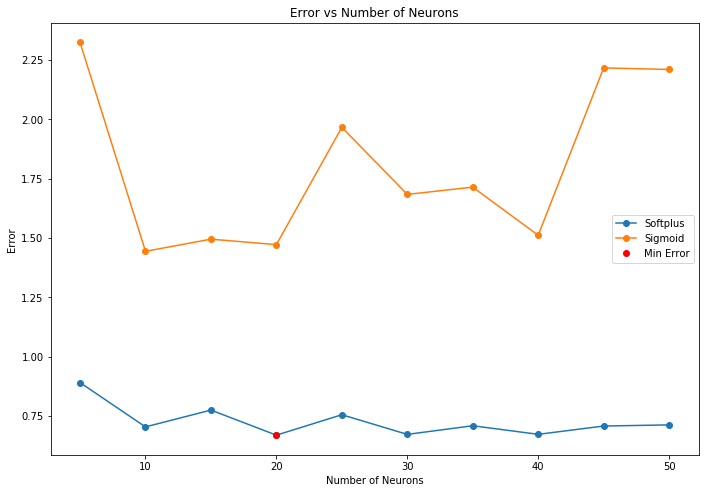

In [25]:
tem = np.min(main_ls_softplus+main_ls_sigmoid)
tem_arg = np.argmin(main_ls_softplus+main_ls_sigmoid)
if tem_arg > 10:
  tem_arg = (abs(10-tem_arg)+1)*5
  bst_activation = 'sigmoid'
else:
  tem_arg = (tem_arg+1)*5
  bst_activation = 'softplus'

plt.axes([1,1,1.5,1.5])
plt.plot([i for i in range(5,51,5)], main_ls_softplus, 'o-')
plt.plot([i for i in range(5,51,5)], main_ls_sigmoid, 'o-')
plt.plot(tem_arg, tem, 'ro')
plt.xlabel('Number of Neurons')
plt.ylabel('Error')
plt.title('Error vs Number of Neurons')
plt.legend(('Softplus', 'Sigmoid', 'Min Error'))


In [28]:
model_new = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(1,)),
            tf.keras.layers.Dense(tem_arg, activation = bst_activation),
            tf.keras.layers.Dense(1, activation = 'linear')
    ])

model_new.compile(loss = 'mean_squared_error', optimizer = 'adam')
model_new.fit(dat[0,:], dat[1,:], epochs=100, batch_size = 100, verbose = 0)

In [29]:
test = model_new.predict(dat_test[0,:])
test[:10]

array([[-0.09196599],
       [-7.960955  ],
       [ 0.12346311],
       [-0.32065314],
       [-0.02102913],
       [ 0.6946389 ],
       [-8.681036  ],
       [-1.6002225 ],
       [-9.405164  ],
       [-8.567359  ]], dtype=float32)

In [30]:
dat_test[1,:10]

array([ 0.47930436, -7.71971203,  0.99409842,  0.52693602,  0.19620978,
        0.53684614, -9.77273888, -0.61058423, -9.84826871, -7.06712676])

In [36]:
np.mean((test.T - dat_test[1,:])**2)

1.8696147886568268

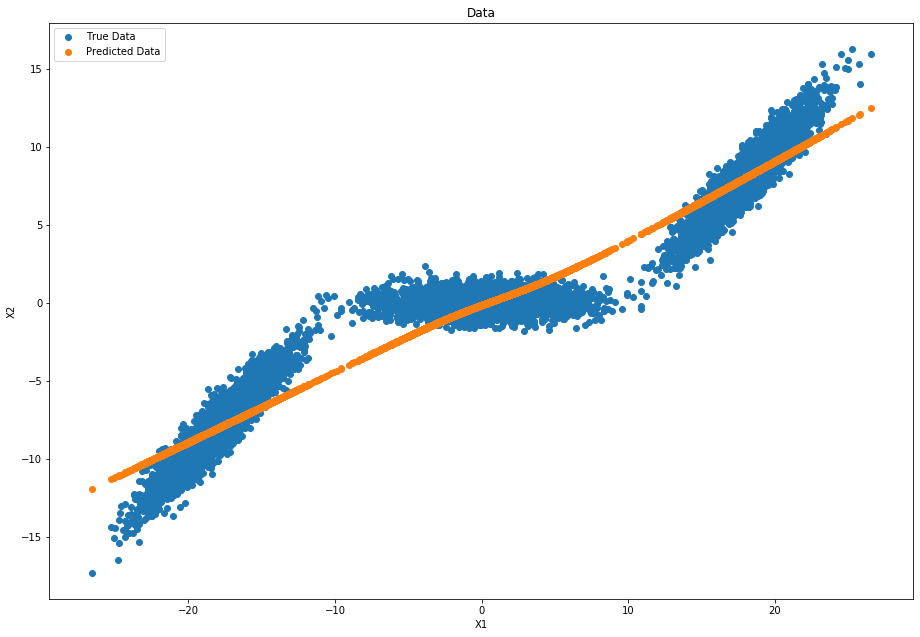

In [47]:
plt.axes([1,1,2,2])
plt.scatter(dat_test[0,:], dat_test[1,:])
plt.scatter(dat_test[0,:], test)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Data')
plt.legend(('True Data', 'Predicted Data'))